**Introduction** 

Baseball is an inherently volatile sport, where hitter performance can swing dramatically from year to year. While some hitters demonstrate consistent excellence, many others experience inconsistencies due to a range of factors. In this analysis, we aim to identify which components of a batter’s skillset are most predictive of offensive value and how accurate we can predict the following seasons offensive value. To quantify offensive performance, we use wRC+ (Weighted Runs Created Plus), a comprehensive metric that accounts for park and league effects, allowing for consistent comparisons across players and seasons.

**Research Question**

Which offensive metrics best explain a player’s value as measured by wRC+, and to what extent can these metrics be used to accurately predict a player’s offensive performance in the following season?

**Data**

Our dataset includes batter statistics from the 2021 to 2024 MLB seasons, sourced from Fangraphs. To ensure statistical significance, we limited the dataset to players with a minimum of 450 plate appearances to ensure a meaningful sample size. We excluded 2020 due to its shortened schedule, which introduced small-sample volatility and potential outliers. We also excluded 2019 because of the league-wide offensive surge caused by the “juiced ball,” which could skew results. 

The data was collected from four core tables for each MLB season: the Advanced, BattedBall, Statcast, and PlateDiscipline tables. Each table provides distinct performance metrics for batters, and all were joined using SQL based on matching year and name columns to create a comprehensive master dataset. To enrich the context of player performance, the ParkFactor table was also joined to the final dataset using the year and team columns, allowing for environmental adjustments based on ballpark characteristics. The resulting master table was carefully structured to avoid redundancy by excluding duplicate name, year, and team columns across the joined tables. The data was then sorted in ascending order by year (from 2021 to 2024), and within each year, teams were ordered in reverse alphabetical order (Z to A). For players who appeared on multiple teams in a single season, their entries were further sorted by the number of teams played for, from most to fewest, to highlight players with mid-season team changes. Linked is the SQL code done to do this.

In [27]:
import pandas as pd

hitters = pd.read_csv('parkfactor.csv', encoding='ISO-8859-1')

# Function to find the longest run of consecutive years
def get_consecutive_runs(years):
    years = sorted(years)
    runs = []
    current_run = [years[0]]

    for i in range(1, len(years)):
        if years[i] == years[i - 1] + 1:
            current_run.append(years[i])
        else:
            runs.append(current_run)
            current_run = [years[i]]
    runs.append(current_run)
    
    return max(runs, key=len) if runs else []

# Calculate wRCplus_next per hitter (shift wRC+ by -1 year)
hitters = hitters.sort_values(['Name', 'Year'])
hitters['wRCplus_next'] = hitters.groupby('Name')['wRC+'].shift(-1)

# For each hitter, find their longest consecutive year run
valid_rows = []

for name, group in hitters.groupby('Name'):
    years = group['Year'].tolist()
    longest_run = get_consecutive_runs(years)
    
    # Keep only hitters with 2 or 4 consecutive years
    if len(longest_run) in [2, 4]:
        filtered_group = group[group['Year'].isin(longest_run)].copy()
        filtered_group['Group'] = f"{len(longest_run)}-year players"
        valid_rows.append(filtered_group)

# Combine all valid hitter data
final_table = pd.concat(valid_rows, ignore_index=True)

# Sort by Name and Year so consecutive years appear together
final_table = final_table.sort_values(['Name', 'Year']).reset_index(drop=True)

print(final_table[['Name', 'Year', 'wRC+', 'wRCplus_next']])
all_cols = final_table.columns.tolist()

cols_front = ['Name', 'Year', 'PA', 'wRC+', 'wRCplus_next']

cols_front = [col for col in cols_front if col in all_cols]

cols_rest = [col for col in all_cols if col not in cols_front]

new_col_order = cols_front + cols_rest

xfinal_table = final_table[new_col_order]

print(xfinal_table)



                      Name  Year  wRC+  wRCplus_next
0              Aaron Judge  2021   150         206.0
1              Aaron Judge  2022   206         173.0
2              Aaron Judge  2023   173         220.0
3              Aaron Judge  2024   220           NaN
4            Adolis García  2021    99         112.0
5            Adolis García  2022   112         128.0
6            Adolis García  2023   128          93.0
7            Adolis García  2024    93           NaN
8             Alex Verdugo  2021   106         102.0
9             Alex Verdugo  2022   102         100.0
10            Alex Verdugo  2023   100          84.0
11            Alex Verdugo  2024    84           NaN
12       Andrew Benintendi  2021   104         121.0
13       Andrew Benintendi  2022   121          88.0
14       Andrew Benintendi  2023    88          93.0
15       Andrew Benintendi  2024    93           NaN
16        Andrew McCutchen  2021   108          98.0
17        Andrew McCutchen  2022    98        

**Metric Selection**

To determine which offensive metrics best predict future performance, we calculated the Pearson correlation between a wide range of batting stats and each player's wRC+ in the following season. To begin, we cleaned percentage-based stats by removing % symbols and converting them to decimals, then included metrics across plate discipline, batted ball profile, contact quality. 

To ensure our model wouldn't be affected by multicollinearity, where highly correlated features distort regression results. To offset this, we calculated the Variance Inflation Factor (VIF) for each offensive metric. A VIF score above 100 typically indicates problematic multicollinearity, with any score under 10 being exceptional. To visualize the results, we created a color-coded table highlighting which metrics had the highest VIF values. Metrics with excessively high VIFs may be considered for removal to improve our model stability and interpretability. When measuring VIF, we end up with: 



In [28]:
metrics = [
    "BB%", "K%", "BB/K", "OPS", "ISO", "BABIP", "wOBA", "AVG", "EV", "OBP",
    "maxEV", "LA", "Contact", "wRAA", 
    "Barrel%", "HardHit%", "xBA", "SLG", "xSLG", "xwOBA", "O_Swing", "PA", "XBR", "wSB", "wRC",
    "Pull%", "Oppo%", "Z_Contact", "SwStr", "LD%", "GB%", "FB%", "HR/FB", "Soft%", "Hard%", "CSW", "ParkFactor", "GB/FB", "IFH%"
]

pct_cols = ["BB%", "K%", "Barrel%", "HardHit%", "wOBA", "xwOBA", "O_Swing", "Z_Contact", "LA", "Contact", "SwStr",
            "LD%", "GB%", "FB%", "HR/FB", "Pull%", "Oppo%", "Soft%", "Hard%", "CSW", "IFH%"]

for col in pct_cols:
    if col in hitters.columns:
        hitters[col] = hitters[col].astype(str).str.replace('%', '', regex=False)
        hitters[col] = pd.to_numeric(hitters[col], errors="coerce") / 100
target_corr = hitters[metrics + ["wRCplus_next"]].corr()["wRCplus_next"].drop("wRCplus_next").sort_values(ascending=False)
print(target_corr)


xwOBA         0.590007
xSLG          0.558774
wRAA          0.506748
OPS           0.504597
wOBA          0.498469
EV            0.495547
Barrel%       0.486636
SLG           0.480929
ISO           0.476582
wRC           0.463107
HardHit%      0.459539
Hard%         0.447378
HR/FB         0.418745
maxEV         0.400744
OBP           0.394291
BB%           0.375180
xBA           0.333702
BB/K          0.277372
FB%           0.199169
AVG           0.172819
PA            0.169144
LA            0.146832
Pull%         0.060657
SwStr         0.042100
K%            0.030848
BABIP         0.013878
IFH%         -0.049019
XBR          -0.071579
wSB          -0.079501
LD%          -0.086431
Z_Contact    -0.090566
Contact      -0.098800
Oppo%        -0.101389
CSW          -0.107874
ParkFactor   -0.132982
O_Swing      -0.145461
GB%          -0.171932
GB/FB        -0.189852
Soft%        -0.226376
Name: wRCplus_next, dtype: float64


In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

X = hitters[metrics].dropna() 
X_scaled = StandardScaler().fit_transform(X)

vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X.shape[1])]

print(vif_df.sort_values("VIF", ascending=False))


       Feature           VIF
3          OPS  32594.365087
17         SLG  24823.160790
31         FB%  15000.940806
4          ISO  14370.824007
30         GB%  14147.152471
9          OBP   4153.169411
7          AVG   3666.074769
29         LD%   2572.445625
6         wOBA    473.422380
19       xwOBA    363.515892
24         wRC    357.956861
18        xSLG    194.151091
13        wRAA    140.396000
12     Contact    107.006782
28       SwStr     91.324881
21          PA     67.953231
5        BABIP     60.833617
1           K%     60.679774
16         xBA     57.982437
14     Barrel%     29.616472
0          BB%     29.306711
11          LA     23.696502
32       HR/FB     23.625868
8           EV     18.826281
15    HardHit%     17.363853
37       GB/FB     15.694403
2         BB/K     13.233666
20     O_Swing      8.257541
34       Hard%      7.238878
27   Z_Contact      6.412017
25       Pull%      5.109056
35         CSW      4.989788
10       maxEV      3.946547
26       Oppo%

From our results, we select

EV


maxEV


HardHit%


Barrel%


HR/FB


wRAA


BB%


CSW


ParkFactor


xBA


xwOBA

**Method**

After deciding which metrics to use, we filtered our dataset to include only players with consistent and relevant year-to-year data. Specifically, we retained hitters who played in consectuve seasons, including

2023-2024 seasons 

2022-2024 seasons 

2021-2024 seasons 

while excluding those with gaps or incomplete spans. This ensured we had a reliable sample of players with back-to-back seasons, allowing us to compare each player's current metrics with their performance in the following year. This step was critical for maintaining consistency in our predictive modeling and year-over-year analysis. 

In [30]:
import pandas as pd

# filters based on the given conditions

def filter_qualified_players(xfinal_table):
    
    # Create a column to identify players appearing in the required years
    valid_years = [2021, 2022, 2023, 2024]
    xfinal_table = xfinal_table[xfinal_table['Year'].isin(valid_years)]        
    qualified_players = []
    
    for player, group in xfinal_table.groupby('Name'):
        years_present = group['Year'].tolist()
        print(f"\nChecking player: {player} with years: {years_present}")
        
        if 2023 in years_present and 2024 in years_present and (2022 not in years_present) and (2021 not in years_present):
            # 2023, 2024
            print(f"  - Player {player} qualifies with years: {years_present} ")
            qualified_players.append(player)
        elif 2022 in years_present and 2023 in years_present and 2024 in years_present and (2021 not in years_present):
            # 2022, 2023, 2024
            print(f"  - Player {player} qualifies with years: {years_present} ")
            qualified_players.append(player)
        elif 2021 in years_present and 2022 in years_present and 2023 in years_present and 2024 in years_present:
            # 2021, 2022, 2023, 2024
            print(f"  - Player {player} qualifies with years: {years_present} ")
            qualified_players.append(player)
        else:
            print(f"  - Player {player} does not qualify")
    
    qualified_table_2024 = xfinal_table[xfinal_table['Name'].isin(qualified_players)]
    print("\nQualified players and data:")
    return qualified_table_2024  

    
qualified_data = filter_qualified_players(xfinal_table)
print("\nAaron Yang:")
print(qualified_data)




Checking player: Aaron Judge with years: [2021, 2022, 2023, 2024]
  - Player Aaron Judge qualifies with years: [2021, 2022, 2023, 2024] 

Checking player: Adolis García with years: [2021, 2022, 2023, 2024]
  - Player Adolis García qualifies with years: [2021, 2022, 2023, 2024] 

Checking player: Alex Verdugo with years: [2021, 2022, 2023, 2024]
  - Player Alex Verdugo qualifies with years: [2021, 2022, 2023, 2024] 

Checking player: Andrew Benintendi with years: [2021, 2022, 2023, 2024]
  - Player Andrew Benintendi qualifies with years: [2021, 2022, 2023, 2024] 

Checking player: Andrew McCutchen with years: [2021, 2022, 2023, 2024]
  - Player Andrew McCutchen qualifies with years: [2021, 2022, 2023, 2024] 

Checking player: Andrew Vaughn with years: [2021, 2022, 2023, 2024]
  - Player Andrew Vaughn qualifies with years: [2021, 2022, 2023, 2024] 

Checking player: Anthony Rizzo with years: [2021, 2022]
  - Player Anthony Rizzo does not qualify

Checking player: Anthony Volpe with year

To predict a player's offensive performance in the 2024 MLB season, we built a regression model that estimates a player’s 2024 wRC+ based on their prior season(s) metrics. Using the list of metrics we chose, we constructed a dataset that summarized each player's performance across multiple seasons. For players with valid 2024 wRC+ values, we averaged their historical metrics to create a single row per player that represents their track record prior to 2024. This averaging approach smooths out year-to-year variability and produces a more stable input for the model.

We then used a Random Forest Regressor, a non-linear ensemble model known for handling high-dimensional and noisy data, to learn the relationship between a player’s prior metrics and their actual 2024 wRC+. Before finalizing the model, we applied a grid search with 10-fold cross-validation to optimize several key hyperparameters, such as the number of trees, tree depth, and minimum sample requirements. This allowed us to find a model configuration that generalizes well without overfitting to the training data.

To assess performance, we evaluated the model on both training and test subsets using Root Mean Squared Error (RMSE) and R² score. These metrics helped us understand both the average prediction error and the proportion of variance in actual 2024 wRC+ that our model could explain. A comparison of predicted vs. actual values was also visualized using a scatter plot, with a line of best fit indicating perfect prediction. Thus, the plot gave a sense of how close each player’s predicted wRC+ was to their actual 2024 wRC+ outcome.

Finally, we produced a results table showing each player’s actual 2024 wRC+ alongside the model’s prediction. This table allows us to directly compare model expectations with real outcomes on a player-by-player basis, offering insights into which players exceeded, met, or fell short of their statistical forecasts. 

Fitting 10 folds for each of 24 candidates, totalling 240 fits

Best Parameters (Simplified Grid):
{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 100}

Performance on Test Set
RMSE: 17.24
R^2: 0.723

Performance on Train Set
RMSE: 12.12
R^2: 0.724


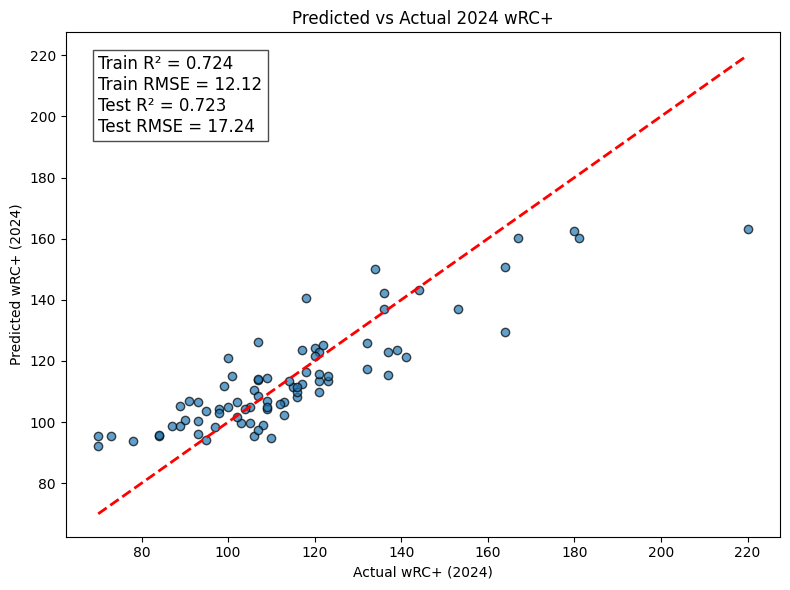


Predicted vs Actual Table (Sorted by Predicted wRC+):
                     Name  Actual_2024_wRC+  Predicted_2024_wRC+  \
0             Aaron Judge               220           163.029857   
1           Shohei Ohtani               180           162.557079   
2          Yordan Alvarez               167           160.362733   
3               Juan Soto               181           160.094213   
4   Vladimir Guerrero Jr.               164           150.674589   
5          Kyle Schwarber               134           150.156510   
6            Bryce Harper               144           143.337500   
7           Rafael Devers               136           142.357215   
8              Matt Olson               118           140.626256   
9        Gunnar Henderson               153           137.029077   
10        Freddie Freeman               136           136.945454   
11           Brent Rooker               164           129.607791   
12            Jake Burger               107           126.125

In [31]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt



metrics = [
    "EV",          
    "HardHit%",   
    "maxEV",       
    "Barrel%",     
    "HR/FB",       
    "wRAA",        
    "BB%",        
    "CSW",        
    "ParkFactor",
    "xBA",
    "xwOBA",
]

pct_cols = ["BB%", "K%", "Barrel%", "HardHit%", "O_Swing", "Z-Contact%", "Contact", "SwStr",
            "LD%", "GB%", "FB%", "HR/FB", "Pull%", "Oppo%", "Soft%", "Hard%", "CSW"]

for col in pct_cols:
    if col in qualified_data.columns:
        qualified_data[col] = qualified_data[col].astype(str).str.replace('%', '', regex=False)
        qualified_data[col] = pd.to_numeric(qualified_data[col], errors='coerce') / 100

valid_metrics = [col for col in metrics if col in qualified_data.columns]

train_rows = []

for name, group in qualified_data.groupby('Name'):
    group = group.sort_values('Year')

    # Keep only years before 2024
    historical = group[group['Year'] < 2024]
    target_row = group[group['Year'] == 2024]

    if historical.empty or target_row.empty:
        continue

    if pd.isna(target_row['wRC+'].values[0]):
        continue


    aggregated = historical[metrics].mean().to_dict()

    row = aggregated.copy()
    row["Name"] = name
    row["wRCplus_2024"] = target_row['wRC+'].values[0]
    train_rows.append(row)



if train_rows:
    full_train_df = pd.DataFrame(train_rows)
else:
    raise ValueError("No training data found — check if 2023 rows are available with 2024 wRC+ targets.")

X = full_train_df[metrics]
y = full_train_df["wRCplus_2024"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Random Forest + Grid Search

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Simple, regularized grid search for less overfitting
param_grid_simple = {
    'n_estimators': [100, 200],  
    'max_depth': [5, 10, 15],     
    'min_samples_split': [10, 15],  
    'min_samples_leaf': [2, 4],    
    'max_features': ['sqrt']  
}


grid_search_simple = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid_simple,
    cv=10,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_search_simple.fit(X, y)

print("\nBest Parameters (Simplified Grid):")
print(grid_search_simple.best_params_)


# Best Model & Predictions
rf_optimized = grid_search_simple.best_estimator_
y_pred_all = rf_optimized.predict(X)
y_pred_test = rf_optimized.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

y_pred_train = rf_optimized.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

print("\nPerformance on Test Set")
print(f"RMSE: {rmse_test:.2f}")
print(f"R^2: {r2_test:.3f}")

print("\nPerformance on Train Set")
print(f"RMSE: {rmse_train:.2f}")
print(f"R^2: {r2_train:.3f}")



# Scatter Plot: Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_all, alpha=0.7, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)

r2_all = r2_score(y, y_pred_all)
rmse_all = np.sqrt(mean_squared_error(y, y_pred_all))

textstr = (
    f"Train R² = {r2_train:.3f}\n"
    f"Train RMSE = {rmse_train:.2f}\n"
    f"Test R² = {r2_test:.3f}\n"
    f"Test RMSE = {rmse_test:.2f}"
)

plt.text(
    x=y.min(), y=y.max(), s=textstr,
    fontsize=12, verticalalignment="top", bbox=dict(facecolor='white', alpha=0.7)
)

plt.title("Predicted vs Actual 2024 wRC+")
plt.xlabel("Actual wRC+ (2024)")
plt.ylabel("Predicted wRC+ (2024)")
plt.tight_layout()
plt.show()


# Predicted and Actual wrC+ Table
results_df = pd.DataFrame({
    "Name": full_train_df["Name"].reset_index(drop=True),
    "Actual_2024_wRC+": full_train_df["wRCplus_2024"].reset_index(drop=True),
    "Predicted_2024_wRC+": pd.Series(y_pred_all).reset_index(drop=True)
})

results_df["wRC+_Difference"] = results_df["Predicted_2024_wRC+"] - results_df["Actual_2024_wRC+"]

results_df = results_df[["Name", "Actual_2024_wRC+", "Predicted_2024_wRC+", "wRC+_Difference"]]

sorted_results_df = results_df.sort_values(by="Predicted_2024_wRC+", ascending=False).reset_index(drop=True)

pd.set_option('display.max_rows', None)

print("\nPredicted vs Actual Table (Sorted by Predicted wRC+):")
print(sorted_results_df)




**Results**

From our results, we can visually see the importance xwOBA and wRAA (<0.40, encouraging)are in our model, followed by HardHit% and HR/FB. We also notice that our train R² score is slightly larger than our test R² score with an RMSE at 12, which is strong. With our test R² above 0.7, this highlights that the model performs quite well at capturing player-level outcomes with a fair amount of accuracy. Out of the full qualified player set (79 players), 26 players fell within ±5 wRC+ of their actual 2024 value, 47 players fell within ±10 wRC+ of their actual 2024 value, and 69 players fell within ±20 wRC+ of their actual 2024 value, which means the model was able to closely mirror real-world performance for a significant portion of the test group. These players include both elite hitters (ex: Bryce Harper, Freddie Freeman) and more average contributors (e.g., Mark Canha, Andrew Vaughn), suggesting that the model’s predictive power is not skewed toward only one end of the performance spectrum. 

At the same time, the distribution of errors shows where limitations still exist. Even among players who landed within the ±5 band, differences as large as 4–5 points remain—enough to influence team-level decisions when projecting roster value. Moreover, while a high R² (0.723 on test data) indicates strong explanatory power, there are still cases outside this range where the model under- or overestimated true performance by larger margins. These gaps likely stem from factors not fully captured by the input features, such as player injuries, swing adjustments, or contextual influences that public datasets do not document. Taken together, the findings suggest that while the model offers a reliable forecasting baseline, incorporating more dynamic or player-specific inputs could further refine predictions.

In [32]:
# Interactive Plot

import plotly.express as px

results_df["wRCplus_Diff"] = results_df["Predicted_2024_wRC+"] - results_df["Actual_2024_wRC+"]

fig = px.scatter(
    results_df,
    x='Actual_2024_wRC+',
    y='Predicted_2024_wRC+',
    color='wRCplus_Diff', 
    color_continuous_scale='RdBu',
    hover_name='Name',
    labels={
        'Actual_2024_wRC+': 'Actual 2024 wRC+',
        'Predicted_2024_wRC+': 'Predicted 2024 wRC+',
        'wRCplus_Diff': 'Difference'
    },
    title='Predicted vs Actual 2024 wRC+'
)

# Add the perfect prediction line (y = x)
fig.add_shape(
    type='line',
    x0=results_df['Actual_2024_wRC+'].min(),
    y0=results_df['Actual_2024_wRC+'].min(),
    x1=results_df['Actual_2024_wRC+'].max(),
    y1=results_df['Actual_2024_wRC+'].max(),
    line=dict(color='Black', dash='dash')
)

textstr = (
    f"Train R² = {r2_train:.3f}<br>"
    f"Train RMSE = {rmse_train:.2f}<br>"
    f"Test R² = {r2_test:.3f}<br>"
    f"Test RMSE = {rmse_test:.2f}"
)


# Performance metrics
fig.add_annotation(
    x=results_df['Actual_2024_wRC+'].min() - 5,   
    y=results_df['Predicted_2024_wRC+'].max() + 45,  
    text=textstr,
    showarrow=False,
    align='left',
    xanchor='left',
    yanchor='top',
    font=dict(size=12, color='black'),
    bordercolor='black',
    borderwidth=1,
    bgcolor='white',
    opacity=0.8
)


# Show plot
fig.show()


In [33]:
fig.write_html("wrcplus_prediction_plot.html")



Top Predictors of Next-Season wRC+:
       Feature  Importance
10       xwOBA    0.194640
5         wRAA    0.140238
1     HardHit%    0.129130
4        HR/FB    0.112615
0           EV    0.109997
3      Barrel%    0.084970
6          BB%    0.084176
2        maxEV    0.073388
9          xBA    0.031744
8   ParkFactor    0.023827
7          CSW    0.015274


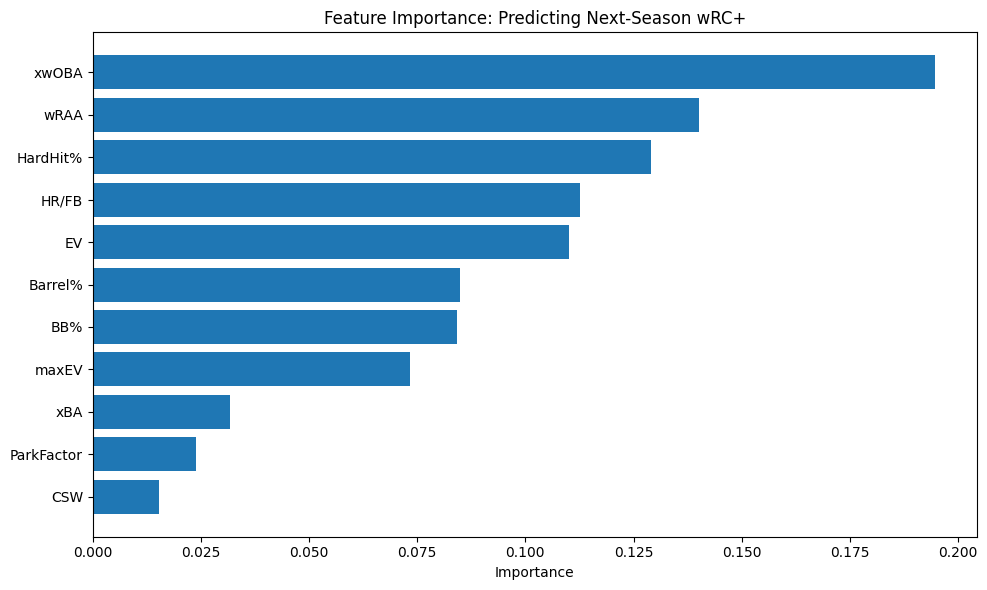

In [34]:
# Feature Importance

importances = pd.DataFrame({
    "Feature": valid_metrics,
    "Importance": rf_optimized.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nTop Predictors of Next-Season wRC+:")
print(importances)

plt.figure(figsize=(10, 6))
plt.barh(importances["Feature"], importances["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance: Predicting Next-Season wRC+")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [35]:
importances.to_csv("feature_importance_wrcplus.csv", index=False)


In [36]:
import plotly.graph_objects as go

# Full table with difference and absolute difference ordered from cloest to farthest
results_df["Diff"] = results_df["Predicted_2024_wRC+"] - results_df["Actual_2024_wRC+"]
results_df["Abs_Diff"] = results_df["Diff"].abs()

pretty_df = results_df.sort_values(by="Abs_Diff", ascending=True).reset_index(drop=True)

fig = go.Figure(data=[go.Table(
    header=dict(
        values=[
            "<b>Player</b>",
            "<b>Predicted wRC+</b>",
            "<b>Actual wRC+</b>",
            "<b>Difference</b>",
        ],
        fill_color='#2a3f5f',
        font=dict(color='white', size=14),
        align='center',
        height=30
    ),
    cells=dict(
        values=[
            pretty_df["Name"],  # or "Player" depending on your column name
            pretty_df["Predicted_2024_wRC+"].round(2),
            pretty_df["Actual_2024_wRC+"].round(2),
            pretty_df["Diff"].round(2),
        ],
        fill_color='lavender',
        font=dict(size=13),
        align='center',
        height=28
    )
)])

fig.update_layout(
    title_text="All Predictions Sorted by Difference (Predicted - Actual wRC+)",
    title_x=0.5,
    margin=dict(l=20, r=20, t=50, b=20)
)

fig.show()

fig.write_html("full_wrcplus_table.html")


In [37]:
pretty_df.to_csv("full_wrcplus_table.csv", index=False)
